## 课时50 TF2.0版本基础CGAN(MNIST)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.__version__

'2.4.0'

### 1. 读取数据以及数据预处理

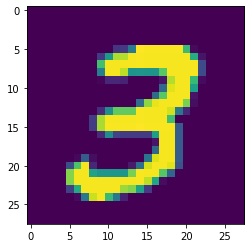

In [4]:
# 导入MNIST数据集
(train_images, train_labels),(_, _) = tf.keras.datasets.mnist.load_data()
plt.imshow(train_images[7])

In [5]:
# 对数据集进行预处理(数据归一化到[-1, 1])
train_images = train_images/127.5 - 1
# 这里CGAN采用的是DCGAN的结构，也就是卷积，因此需要将图片数据的第三个维度扩充起来，也可以使用reshap的方式
# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
train_images = np.expand_dims(train_images, -1)

In [6]:
# 将数据转换为datasets
train_datasets = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_datasets

<TensorSliceDataset shapes: ((28, 28, 1), ()), types: (tf.float64, tf.uint8)>

In [8]:
# 定义参量，并进行数据乱序和batch批次化
BATCH_SIZE = 256
noise_dim = 100
train_datasets = train_datasets.shuffle(60000).batch(BATCH_SIZE)

### 2. 定义生成器和判别器模型

由于涉及到计算卷积与反卷积尺寸计算的内容，因此记录如下：
>1. 在TensorFlow2.1.0版本中，padding的same卷积后尺寸是否不变由步长strides是否大于1决定。对于转置卷积和卷积，padding的"same"与"valid"中，输入高宽（$i$），输出高宽（$o$），步长（$s$），卷积核的高宽（$k$）（设定高宽相等都为$k$）满足以下关系：
>2. 卷积：
    - padding = "same"时，$o = \frac{i}{s}$, **向上取整**;
    - padding = "valid"时，$o = \frac{(i-k)}{s} + 1$, **向下取整**;
    
>3. 转置卷积：
    - padding = "same"时，$o = i * s$;
    - padding = "valid"时，$o = (i-1)*s+k$;
>4. https://www.zhihu.com/question/60285234/answer/1002846390

In [18]:
def generator_model():
    # 由于是两个输入，单纯的Sequential模型已经不能满足了，因此采用的是函数式API进行模型搭建
    noise = tf.keras.layers.Input(shape=((noise_dim,)))
    # 这里的标签值是一个单个的值，可以从train_datasets中可以看出来, 因此shape是一个()元祖
    condition_label = tf.keras.layers.Input(shape=(()))
    
    # 需要将输入的noise和condition_label进行合并concat
    # 在进行合并之前，由于condition_label的shape=()，不太好进行合并
    # 因此需要使用Embedding函数将其转换成我们制定shape的一个向量才好进行合并
    # 其中output_dim=100代表将condition_label映射到长度与noise长度相同的维度
    # https://www.jianshu.com/p/e8986d0ff4ff
    # https://blog.csdn.net/claroja/article/details/95196612
    # 需要注意的是input_dim代表的是整个数据的词汇表的个数，这里整个MNIST数据集也就是10个数字
    # 而input_length则代表每次输入的序列的长度。
    x = tf.keras.layers.Embedding(input_dim=10, output_dim=100, 
                                  input_length=1)(condition_label)
    # 将random vector与condition_label进行合并
    x = tf.keras.layers.concatenate([noise, x])
    # 合并完成之后，现在再利用全连接层将现在合并完之后的向量转换为合适shape的向量
    # 方便后续以合适shape的向量为基准开始反卷积，直到反卷积到合适尺寸的图片大小
    x = tf.keras.layers.Dense(units=3*3*128, use_bias=False)(x)
    x = tf.keras.layers.Reshape(target_shape=(3, 3, 128))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # [7, 7, 64] 采用valid方式计算之后正好就是7 * 7大小
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), 
                                        strides=(2, 2), use_bias=False，                                                    padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # [14, 14, 32]
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), 
                                        strides=(2, 2), use_bias=False，                                                    padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # [28, 28, 1]
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), 
                                        strides=(2, 2), use_bias=False,                                                     padding='same')(x)
    # 因为输入的数据的范围是[-1, 1]，因此采用tanh
    x = tf.keras.layers.Activation('tanh')(x)
    
    model = tf.keras.Model(inputs=[noise, condition_label], outputs=x)
    return model

In [19]:
def discriminator_model():
    # CGAN中discriminator在设计的时候对于condition_label的位置可以放在前面或者后面的
    # 也就是说condition_label可以放在一开始图片输入的位置进行合并，然后一层层提取特征，直到最后进行概率判断
    # 也可以等图片特征提取完毕开始准备传入到后续全连接层之前的时候进行合并，然后进行概率判断
    # 与DCGAN不同的是，输入D的不光只有图片，还有想要的label
    input_image = tf.keras.layers.Input(shape=((28,28,1)))
    condition_label = tf.keras.layers.Input(shape=(()))
    
    x = tf.keras.layers.Embedding(input_dim=10, output_dim=28*28, 
                                  input_length=1)(condition_label)
    x = tf.keras.layers.Reshape(target_shape=((28, 28, 1)))(x)
    x = tf.keras.layers.concatenate([input_image, x])
    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), 
                               padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), 
                               padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), 
                               padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    
    x = tf.keras.layers.Flatten()(x)
    output_logits = tf.keras.layers.Dense(units=1)(x)
    
    model = tf.keras.Model(inputs=[input_image, condition_label],                                              outputs=output_logits)
    return model

## 3. 定义损失函数及优化器

In [20]:
generator = generator_model()
discriminator = discriminator_model()

In [21]:
Binary_Crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(real_image_outputs, fake_image_outputs):
    real_image_loss = Binary_Crossentropy(y_true=tf.ones_like(real_image_outputs),                                            y_pred=real_image_outputs)
    fake_image_loss = Binary_Crossentropy(y_true=tf.zeros_like(fake_image_outputs),                                           y_pred=fake_image_outputs)
    return real_image_loss + fake_image_loss

In [23]:
def generator_loss(fake_image_outputs):
    return Binary_Crossentropy(y_true=tf.ones_like(fake_image_outputs),                                            y_pred=fake_image_outputs)

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

## 4. 定义梯度更新函数

In [31]:
@tf.function
def train_step(images, labels):
    batchsize = labels.shape[0]
    noise = tf.random.normal([batchsize, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(inputs=(noise, labels), training=True)
        fake_image_out = discriminator(inputs=(generated_images, labels),                                                  training=True)
        real_image_out = discriminator(inputs=(images, labels), 
                                       training=True)
        
        generator_loss_ = generator_loss(fake_image_out)
        discriminator_loss_ = discriminator_loss(real_image_out, fake_image_out)
        
    generator_gradients = gen_tape.gradient(generator_loss_,                                                                    generator.trainable_variables)
    disciminator_gradients = disc_tape.gradient(discriminator_loss_,                                                                discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients,                                                                generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disciminator_gradients,                                                             discriminator.trainable_variables))

## 5. 定义辅助绘图函数

In [28]:
# 设置模型训练后期查看模型效果的noise和label，这里取定了之后可以在后续展示的时候展示一样的图片
noise_seed = tf.random.normal([10, noise_dim])
label_seed = np.random.randint(0, 10, size=(10, 1))

In [27]:
def plot_generator_images(model, noise, label, epoch_num):
    print('现在是第%i个epoch.'%(epoch_num))
    generated_images = model(inputs=(noise, label), training=False)
    # 将shape为[None, 28, 28, 1]的图像转换为[None, 28, 28]
    generated_images = tf.squeeze(generated_images)
    fig = plt.figure(figsize=(10, 1))
    for i in range(generated_images.shape[0]):
        plt.subplot(1, 10, i+1)
        plt.imshow((generated_images[i, :, :, :]+1)/2)
        plt.axis('off')
    plt.show()

## 6. 定义模型训练函数

In [36]:
def train(datasets, epochs):
    for epoch in range(epochs):
        print('Epoch is:', epoch)
        for images_batch, labels_batch in datasets:
            train_step(images_batch, labels_batch)
            print('.', end=' ')
        print()
        if epoch % 10 == 0:
            plot_generator_images(generator, noise_seed, label_seed, epoch)
    plot_generator_images(generator, noise_seed, label_seed, epoch)

In [37]:
train(train_datasets, 200)

In [ ]:
generator.save('generate_v2.h5')
num = 10
noise_seed = tf.random.normal([num, noise_dim])
cat_seed = np.arange(10).reshape(-1, 1)
print(cat_seed.T)

In [ ]:
generate_images(generator, noise_seed, cat_seed, 1)

In [ ]:
cat_seed = np.array([3]*10)
generate_images(generator, noise_seed, cat_seed, 0)

In [ ]:
cat_seed = np.array([6]*10)
generate_images(generator, noise_seed, cat_seed, 0)